1. Business Problem & Objective
2. Dataset Description
3. Data Loading
4. Exploratory Data Analysis (EDA)
5. Image Preprocessing & Augmentation
6. Model Architecture (Transfer Learning)
7. Training
8. Evaluation Metrics
9. Observations & Learnings
10. Limitations & Future Improvements
Severstal: Steel Defect Detection (Kaggle Competition)
👉 https://www.kaggle.com/c/severstal-steel-defect-detection/data

1.🧠Business Understanding:

**🎯 Goal:**
To build an AI-based computer vision model that automatically detects and localizes surface defects in steel sheet images, enabling faster, more consistent, and scalable quality inspection in industrial manufacturing.

**💼 Why It’s Important:**

Automated defect detection enables:
faster, more consistent, and scalable quality inspection in industrial manufacturing.

**👥 Target Audience:**
Manufacturing & Quality Control Teams – to identify defects early in the production line
**📊 Success Metrics:**
The primary evaluation metric is the Mean Dice Coefficient, which measures pixel-level overlap between predicted defect regions and ground truth annotations by segementing image
Others:
Strong defect localization accuracy
High recall and F1 score to minimize missed defects
In an industrial context, missing a defect is more costly than a false alarm, so recall and segmentation quality are critical.

**💡 Hypotheses:**
1. Business Hypotheses
• Automated inspection can reduce manual effort and subjectivity
• High-recall systems can prevent defective products from reaching customers
• Structured defect data can support process improvement
2. Technical Hypotheses
• CNNs can learn visual patterns of surface defects
• Transfer learning can improve performance with limited data
• Data augmentation can mitigate class imbalance
• Dice coefficient is a suitable metric for segmentation tasks

2.**📊 Data Collection & Understanding**

🧾 Key Parameters to Evaluate During Data Collection:
1. Relevance → (Check all the features are covered)
2. Accuracy→ (Compare with trusted source or sample audit)
3. Completeness →
4. Consistency →(Group by differenct type of observation and check
                with industry benchmark)
5. Timeliness →
6. Bias→

Dataset Context

Input features:

ImageId – unique identifier for each steel sheet image

ClassId – defect type (1 to 4)

EncodedPixels – run-length encoded segmentation mask

Target:

Pixel-level defect localization and classification

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
import os
os.environ['KAGGLE_API_TOKEN']="KGAT_0669079108c1aa5d41e9412323972749"

In [4]:
pip install kaggle

In [5]:
mkdir -p /root/.config/kaggle

In [6]:
import json, os

kaggle_dict = {
    "username": "Umananth R",
    "key": "KGAT_0669079108c1aa5d41e9412323972749"
}

with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_dict, f)

In [7]:
!kaggle competitions download -c severstal-steel-defect-detection

 98% 1.53G/1.57G [00:17<00:00, 75.6MB/s]
100% 1.57G/1.57G [00:17<00:00, 93.7MB/s]


In [8]:
!unzip -o severstal-steel-defect-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/99f75320d.jpg  
  inflating: train_images/99f9d2375.jpg  
  inflating: train_images/99fd3c6f5.jpg  
  inflating: train_images/9a016fe15.jpg  
  inflating: train_images/9a064450d.jpg  
  inflating: train_images/9a08c2783.jpg  
  inflating: train_images/9a18e4457.jpg  
  inflating: train_images/9a1f7c238.jpg  
  inflating: train_images/9a2523ce9.jpg  
  inflating: train_images/9a3e774ff.jpg  
  inflating: train_images/9a5e9e77c.jpg  
  inflating: train_images/9a5f7a855.jpg  
  inflating: train_images/9a62177bb.jpg  
  inflating: train_images/9a67575cf.jpg  
  inflating: train_images/9a6ac5406.jpg  
  inflating: train_images/9a70057c0.jpg  
  inflating: train_images/9a72fd89e.jpg  
  inflating: train_images/9a75974ba.jpg  
  inflating: train_images/9a762b892.jpg  
  inflating: train_images/9a7b2f3af.jpg  
  inflating: train_images/9a7b427b4.jpg  
  inflating: train_images/9a81a8056.jpg  
  inflating: train_images

In [9]:
ls

sample_data/           severstal-steel-defect-detection.zip  train.csv
sample_submission.csv  test_images/                          train_images/


In [10]:
print("Train images:",len(os.listdir("train_images")))
print("Test images:",len(os.listdir("test_images")))

Train images: 12568
Test images: 5506


2.1 Train.csv EDA

In [11]:
df=pd.read_csv('train.csv')

In [12]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [14]:
df['ClassId'] = df['ClassId'].astype(str)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   object
 2   EncodedPixels  7095 non-null   object
dtypes: object(3)
memory usage: 166.4+ KB


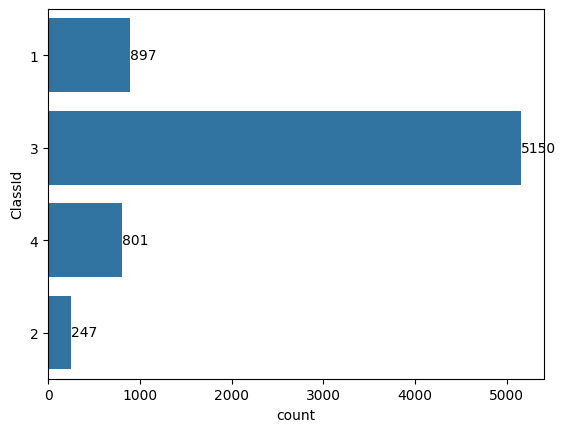

In [16]:
ax=sns.countplot(df['ClassId'])
for container in ax.containers:
  ax.bar_label(container)

**Inference**:There is significant class imbalance, with Class 3 being the most frequent and Class 2 the rarest. This reflects real industrial conditions and motivates the use of recall-focused metrics and imbalance-aware modeling strategies.

In [17]:
df['ImageId'].duplicated().sum()

np.int64(429)

In [18]:
duplicate_image_ids = df['ImageId'].value_counts()
duplicate_image_ids = duplicate_image_ids[duplicate_image_ids==1].index
df[df['ImageId'].isin(duplicate_image_ids)].count()

,0
ImageId,6239
ClassId,6239
EncodedPixels,6239


In [19]:
# Get image IDs that appear more than Once
duplicate_image_ids = df['ImageId'].value_counts()
duplicate_image_ids = duplicate_image_ids[duplicate_image_ids==2].index
df[df['ImageId'].isin(duplicate_image_ids)].count()

,0
ImageId,850
ClassId,850
EncodedPixels,850


In [20]:
# Get image IDs that appear more than twice
duplicate_image_ids = df['ImageId'].value_counts()
duplicate_image_ids = duplicate_image_ids[duplicate_image_ids==3].index
df[df['ImageId'].isin(duplicate_image_ids)].count()

,0
ImageId,6
ClassId,6
EncodedPixels,6


In [21]:
df['ImageId'].nunique()

6666

**Inference:**
Out of 7,065 total records, 6,666 images are unique (single defect per image).
The remaining images contain multiple defects:
– 6 images have three defects each
– The rest have two defects per image

In [22]:
df['EncodedPixels'].nunique()

7095

In [23]:
df['EncodedPixels'].isnull().sum()

np.int64(0)

In [24]:
df.groupby('ImageId')['ClassId'].count().describe()

,ClassId
count,6666.000000
mean,1.064356
std,0.246625
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


Inference:There are no missing segmentation labels; non-defective images are represented using empty masks

In [25]:
(df['EncodedPixels'] == '').sum()

np.int64(0)

2.1 train_images EDA

For image EDA, focus on:

Image shape & resolution

Image intensity distribution

Visual variability

Relation between image & mask size

Sample defect visualization

In [26]:
Train_images=set(os.listdir('train_images'))
print("Total_Images:",len(Train_images))


Total_Images: 12568


**Inference**:out 12568 images 7095 are defective 56%
so create empty masks for defect-free images.
This ensures the model learns both:
Where defects are
When there are no defects

2.1.1 Load and inspect a few images

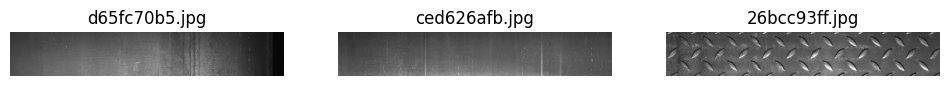

In [27]:
Image_Path='/content/train_images'
#In Colab, /content/ is the working directory
import random
sample_image=random.sample(os.listdir(Image_Path),3)
plt.figure(figsize=(12,8))
for i,image_name in enumerate(sample_image):
  #enumerate gives:i → index (0, 1, 2)img_name → image file name
  img=cv2.imread(os.path.join(Image_Path,image_name),cv2.IMREAD_COLOR)
  #cv2.IMREAD_GRAYSCALE loads an image as a single-channel intensity matrix, which is ideal for texture-based defect detection tasks.
  plt.subplot(1,3,i+1)
  plt.imshow(img,cmap='gray')
  plt.title(image_name)
  plt.axis('off')
plt.show()


2.1.2 Check image dimensions

In [28]:
img1 = cv2.imread(os.path.join(Image_Path,sample_image[1]), cv2.IMREAD_GRAYSCALE)
img1.shape
#256 pixels in height (rows)
#1600 pixels in width (columns)

(256, 1600)

In [29]:
#Quick sanity check
Image_Path='/content/train_images'
shapes = set()
for img_name in os.listdir(Image_Path):
    img = cv2.imread(os.path.join(Image_Path, img_name), cv2.IMREAD_GRAYSCALE)
    shapes.add(img.shape)

shapes

{(256, 1600)}

**Inference:**All images have the same resolution
Note:If If output is {(256, 1600), (300, 1600), (350, 1600)} Images have different resolutions

2.1.3 Pixel intensity distribution

Pixel intensity = 120 means:

Brightness value of one pixel

In grayscale:
0 → black
255 → white
120 → medium gray

In [30]:
sample_image1=(os.listdir(Image_Path))
for i,image_name in enumerate(sample_image1):
  img2=cv2.imread(os.path.join(Image_Path,image_name),cv2.IMREAD_COLOR)

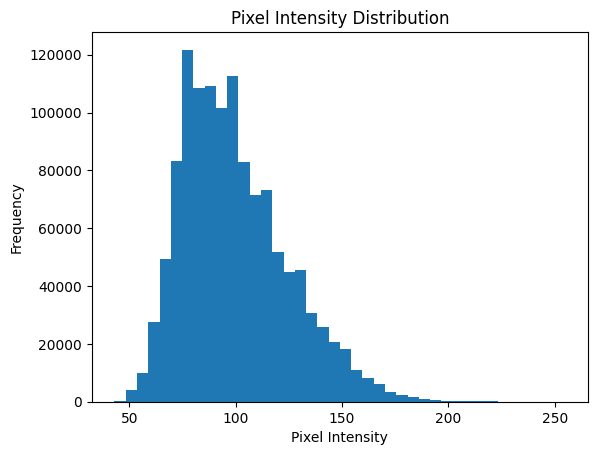

In [31]:
pixels=img2.flatten()
plt.hist(pixels,bins=40)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

**Inference:**The pixel intensity distribution is approximately normal, centered around mid-gray values, indicating uniform illumination and sufficient contrast for effective defect detection
**A bell-shaped histogram means:**
Most pixels have similar brightness
Values gradually decrease toward darker and brighter sides
No sudden spikes at very low or very high values

**This happens when:**
✔ Lighting is uniform
✔ Camera exposure is stable
✔ Surface is evenly visible

2.1.4 Mask size analysis & Relation between image & mask size

In [32]:
def rle_decode(mask_rle, shape=(256,1600)):
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]
    starts = [x-1 for x in starts]
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        mask[start:start+length] = 1
    return mask.reshape(shape, order='F')

In [33]:
df['defect_area'] = df['EncodedPixels'].apply(
    lambda x: np.sum(rle_decode(x))
)

df['defect_area'].describe()

,defect_area
count,7095.000000
mean,23056.669626
std,34957.878108
min,115.000000
25%,4251.000000
50%,10341.000000
75%,26791.000000
max,368240.000000


***Key Observations***

**Defects occupy a small portion of the image:**
Median defect area ≈ 10,341 pixels
This is only ~2.5% of the total image area
Confirms that defects are spatially sparse

**High variability in defect size**
Standard deviation (34,958) is larger than the mean (23,056)
Indicates wide variation in defect shapes and sizes
Some defects are tiny scratches, others are large surface flaws.

**Long-tailed distribution**
Minimum defect area: 115 pixels (very small defects)
Maximum defect area: 368,240 pixels (~90% of image)
Suggests presence of rare but severe defects

Most defects are relatively small
75% of defects are below 26,791 pixels (~6.5% of image)
Model must be sensitive to small localized patterns

2.1.5 Visual EDA: Decode Masks & Overlay on Images

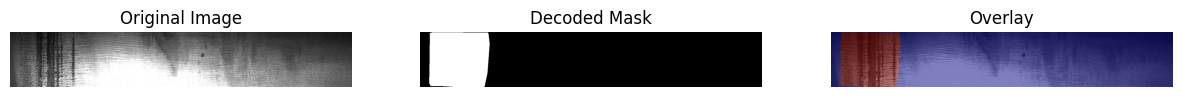

In [34]:
row = df.sample(1).iloc[0]
img = cv2.imread(os.path.join(Image_Path, row['ImageId']), cv2.IMREAD_GRAYSCALE)
mask = rle_decode(row['EncodedPixels'])

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title("Decoded Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='jet', alpha=0.5)
plt.title("Overlay")
plt.axis('off')

plt.show()


**Inference:**“Overlay visualization confirms accurate RLE decoding and precise alignment of defect masks with the original tyre surface. Defects are extremely thin and localized, occupying a very small fraction of the image area, indicating strong class imbalance and the need for high-resolution inputs and segmentation-aware loss functions.”

2.2 test_images EDA

In [35]:
test_images=set(os.listdir('test_images'))
print("Test_Images:",len(test_images))

Test_Images: 5506


In [36]:
#Quick sanity check
Image_Path='/content/test_images'
shapes = set()
for img_name in os.listdir(Image_Path):
    img = cv2.imread(os.path.join(Image_Path, img_name), cv2.IMREAD_GRAYSCALE)
    shapes.add(img.shape)

shapes

{(256, 1600)}

3.📊 Image Preprocessing

3.1 Resize Images:

In [37]:
Image_Size=256
def Image_preprocessing(img):
  img=cv2.resize(img,(Image_Size,Image_Size))
  return img



example_encoded_pixels = df['EncodedPixels'].iloc[0]
decoded_mask = rle_decode(example_encoded_pixels)

def mask_preprocessing(input_mask):
    processed_mask = cv2.resize(input_mask, (Image_Size, Image_Size),
                                 interpolation=cv2.INTER_NEAREST)
    return processed_mask


mask = mask_preprocessing(decoded_mask)

In [38]:
img.shape
mask.shape

(256, 256)

In [39]:
print(mask_preprocessing(mask).max())
print(mask_preprocessing(mask).min())

1
0


In [40]:
df['EncodedPixels']

,EncodedPixels
0,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,18661 28 18863 82 19091 110 19347 110 19603 11...
2,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,229501 11 229741 33 229981 55 230221 77 230468...
...,...
7090,121911 34 122167 101 122422 169 122678 203 122...
7091,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,16899 7 17155 20 17411 34 17667 47 17923 60 18...


Note:Image preprocessing includes resizing all images and masks to a fixed resolution (256×256).
This ensures consistent model input dimensions and reduces computational overhead.
Nearest-neighbor interpolation is used for masks to preserve pixel-level labels.
Note:Gentrally CV2 uses INTER_LINEAR (default for images)
This averages pixels.

3.1 Data Augmentation:

“Due to class imbalance and small defect regions, data augmentation was applied only on the training set. Augmentations were chosen carefully to preserve defect geometry while improving robustness to lighting and orientation variations.”

In [41]:
import albumentations as A
Light_aug=A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Rotate(limit=5,p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Resize(256,256)
])

In [42]:
Strong_aug=A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20,p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.4),
    A.ElasticTransform(p=0.4),
    A.Resize(256,256)
])

In [43]:
def Augmented_image_mask(image,mask,ClassId):
  if ClassId==3:
    augmented=Light_aug(image=image,mask=mask)
  else:
    augmented=Strong_aug(image=image,mask=mask)
    return augmented['image'],augmented['mask']

“Industrial defect datasets are inherently imbalanced. We handled this using recall-focused metrics, stronger augmentation for minority classes, and Dice-based loss functions to ensure rare defects are not ignored.”

3.2 Dataset & DataLoader creation

Dataset → defines how to read image + mask

DataLoader → handles batching, shuffling, parallel loading

3.2.1 Custom Dataset class

In [44]:
#First: Prepare a helper to create masks per image
def get_mask_for_image(image_id, df, img_shape=(256, 1600)):
    records = df[df['ImageId'] == image_id]
    mask = np.zeros(img_shape, dtype=np.uint8)

    for _, row in records.iterrows():
        if pd.notna(row['EncodedPixels']):
            decoded = rle_decode(row['EncodedPixels'], img_shape)
            mask = np.maximum(mask, decoded)

    return mask

    #For each defect in the image, decode its mask and merge it into a single final mask.

In [45]:
#Create Custom PyTorch Dataset
from torch.utils.data import Dataset
import torch
class SeverstalDataset(Dataset):
    def __init__(self, df, image_dir, augment=True):
        self.df = df
        self.image_dir = image_dir
        self.image_ids = df['ImageId'].unique()
        self.augment = augment

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, image_id)

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image_preprocessing(image)

        # Load mask
        mask = get_mask_for_image(image_id, self.df)
        mask = mask_preprocessing(mask)

        # Get dominant ClassId (for augmentation decision)
        class_ids = self.df[self.df['ImageId'] == image_id]['ClassId']
        class_id = class_ids.mode()[0] if len(class_ids) > 0 else 0

        # Apply augmentation
        if self.augment:
            image, mask = Augmented_image_mask(image, mask, class_id)

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

In [46]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
#Setted Random seeds across Python, NumPy, and PyTorch, and enforce deterministic GPU behavior to ensure reproducible training and evaluation.

In [ ]:
#Create Train / Validation Split
from sklearn.model_selection import train_test_split

train_id,val_id=train_test_split(df['ImageId'].unique(),test_size=0.2,random_state=42)
train_df=df[df['ImageId'].isin(train_id)]
val_df=df[df['ImageId'].isin(val_id)]

In [ ]:
val_df.head()

,ImageId,ClassId,EncodedPixels,defect_area
10,0030401a5.jpg,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...,60738
16,0088260da.jpg,3,26044 13 26283 40 26522 67 26762 92 27001 119 ...,86663
17,008d0f87b.jpg,3,72425 21 72641 61 72856 102 73071 142 73287 18...,10509
20,0095cd374.jpg,3,10674 18 10926 48 11178 52 11430 56 11682 60 1...,11749
23,00af2671f.jpg,3,155585 64 155713 5542 161281 179 161537 128 16...,37903


In [ ]:
#Create Dataset Objects
train_dataset = SeverstalDataset(
    df=train_df,
    image_dir='train_images',
    augment=True
)

val_dataset = SeverstalDataset(
    df=val_df,
    image_dir='train_images',
    augment=False
)

In [ ]:
#Create DataLoaders
from torch.utils.data import DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2
)

In [ ]:
images, masks = next(iter(train_loader))
print(images.shape)  # (B, 3, 256, 256)
print(masks.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


“I created a custom PyTorch Dataset to load images and decode RLE masks, applied class-aware augmentation to handle imbalance, and used DataLoader for efficient batching during training.”

6. Model Architecture (Transfer Learning)

Model: U-Net with pretrained encoder (ResNet/EfficientNet)
Loss: Dice Loss + Binary Cross Entropy
Optimizer: Adam
Metric: Mean Dice Coefficient


In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.0 MB/s eta 0:00:00


6.1 Model Definition

In [ ]:
import segmentation_models_pytorch as smp
Device='cuda' if torch.cuda.is_available() else 'cpu'
model=smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1

)
model=model.to(Device)

In [ ]:
print(Device)

cuda


“I used an NVIDIA T4 GPU since PyTorch has native CUDA support, whereas TPUs require additional frameworks like torch_xla and are not plug-and-play for PyTorch models

“I defined a U-Net segmentation model with a ResNet34 encoder pretrained on ImageNet to leverage transfer learning. This setup enables accurate pixel-level defect segmentation while training efficiently on limited data.”

6.2 Loss Functions

In [ ]:
dice_loss=smp.losses.DiceLoss(mode='binary')
bce_loss=torch.nn.BCEWithLogitsLoss()
def combined_loss(pred, target):
   return dice_loss(pred,target)+bce_loss(pred, target)

6.3 Optimizer & Scheduler

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=2,factor=0.5)


7. Training

7.1  Full Training Loop

In [ ]:
from tqdm import tqdm
def train_one_epoch(model,loader):
  model.train()
  running_Loss=0

  for images,masks in tqdm(loader):
    images=images.to(Device)
    masks=masks.to(Device)
    optimizer.zero_grad()

    outputs=model(images)
    loss=combined_loss(outputs,masks)
    loss.backward()
    optimizer.step()

    running_Loss+=loss.item()
  return running_Loss/len(loader)

def validate_one_epoch(model, loader):
  model.eval()
  running_Loss=0
  with torch.no_grad():
    for images,masks in tqdm(loader):
      images=images.to(Device)
      masks=masks.to(Device)

      outputs=model(images)
      loss=combined_loss(outputs,masks)

      running_Loss+=loss.item()
  return running_Loss/len(loader)

7.2 Training Driver Code

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
  train_loss=train_one_epoch(model,train_loader)
  val_loss=validate_one_epoch(model,val_loader)
  scheduler.step(val_loss)

  print(f'''Epoch:[{epoch+1}/{EPOCHS}]
        Train_loss:{train_loss:.4f}
        val_loss:{val_loss:.4f}''')

#torch.save(model.state_dict(), "unet_segmentation.pth")

100%|██████████| 167/167 [00:10<00:00, 15.84it/s]


Epoch:[1/10]
        Train_loss:0.6748
        val_loss:0.5815


100%|██████████| 167/167 [00:10<00:00, 15.99it/s]


Epoch:[2/10]
        Train_loss:0.6799
        val_loss:0.5742


100%|██████████| 167/167 [00:09<00:00, 16.74it/s]


Epoch:[3/10]
        Train_loss:0.6735
        val_loss:0.5776


100%|██████████| 167/167 [00:10<00:00, 16.18it/s]


Epoch:[4/10]
        Train_loss:0.6737
        val_loss:0.5912


100%|██████████| 167/167 [00:10<00:00, 16.15it/s]


Epoch:[5/10]
        Train_loss:0.6651
        val_loss:0.5636


100%|██████████| 167/167 [00:09<00:00, 18.02it/s]


Epoch:[6/10]
        Train_loss:0.6614
        val_loss:0.5645


100%|██████████| 167/167 [00:10<00:00, 16.17it/s]


Epoch:[7/10]
        Train_loss:0.6601
        val_loss:0.5716


100%|██████████| 167/167 [00:08<00:00, 18.69it/s]


Epoch:[8/10]
        Train_loss:0.6551
        val_loss:0.5562


100%|██████████| 167/167 [00:10<00:00, 16.02it/s]


Epoch:[9/10]
        Train_loss:0.6538
        val_loss:0.5502


100%|██████████| 167/167 [00:09<00:00, 17.42it/s]

Epoch:[10/10]
        Train_loss:0.6428
        val_loss:0.5583


In [ ]:
#model.load_state_dict(torch.load("unet_segmentation.pth", map_location=Device))
#model.eval()
#print("Model loaded. No training needed.")

8.Evaluation Metrics

8.1 Dice score function

In [ ]:
def dice_score(preds,targets,smooth=1e-6):
    preds=torch.sigmoid(preds)
    preds=(preds>0.5).float()
    preds=preds.view(-1)
    targets=targets.view(-1)
    intersection=(preds*targets).sum()
    #Dice = 2 × overlap / (prediction + ground truth)
    Dice=(2.0*intersection+smooth)/(preds.sum()+targets.sum()+smooth)
    return Dice

8.2 Validation Dice evaluation loop

In [ ]:
def evaluate_dice(model,loader,device):
  model.eval()
  dice_scores=[]
  with torch.no_grad():
    for images, masks in loader:
      images=images.to(device)
      masks=masks.to(device)

      outputs=model(images)
      dice=dice_score(outputs,masks)
      dice_scores.append(dice.item())
  return sum(dice_scores)/len(dice_scores)

In [ ]:
#Run Dice evaluation
val_dice=evaluate_dice(model,val_loader,Device)
print(f'evaluate_dice:{val_dice:.4f}')

evaluate_dice:0.6014


In [ ]:
#Run Dice evaluation in Traning Data Set
#Train_dice=evaluate_dice(model,train_loader,Device)
#print(f'Train_dice:{Train_dice:.4f}')

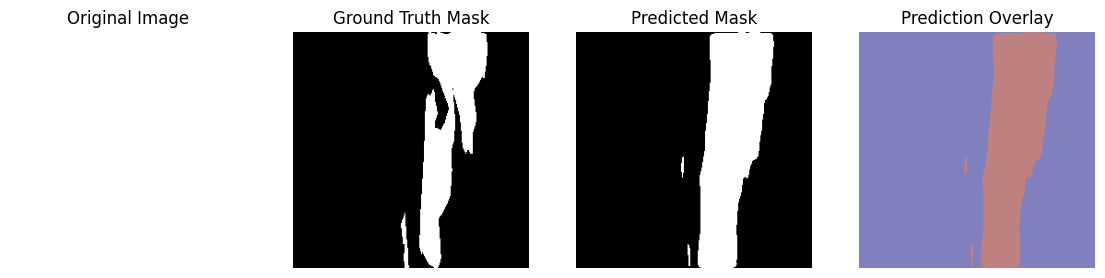

In [ ]:
#One-time prediction visualization
model.eval()
images, masks = next(iter(val_loader))

images = images.to(Device)
masks = masks.to(Device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()

# Move to CPU
image = images[0].cpu().permute(1, 2, 0).numpy()
gt_mask = masks[0][0].cpu().numpy()
pred_mask = preds[0][0].cpu().numpy()

# Plot
plt.figure(figsize=(14,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(gt_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(image)
plt.imshow(pred_mask, cmap="jet", alpha=0.5)
plt.title("Prediction Overlay")
plt.axis("off")

plt.show()

In [ ]:
#Compute Recall and FN
import torch

def compute_metrics(model, dataloader, device, threshold=0.5):
    model.eval()

    TP = FP = TN = FN = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)              # logits
            probs = torch.sigmoid(outputs)       # probabilities
            preds = (probs > threshold).float()  # binary mask

            # Flatten
            preds = preds.view(-1)
            masks = masks.view(-1)

            TP += ((preds == 1) & (masks == 1)).sum().item()
            FP += ((preds == 1) & (masks == 0)).sum().item()
            TN += ((preds == 0) & (masks == 0)).sum().item()
            FN += ((preds == 0) & (masks == 1)).sum().item()

    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-6)
    specificity = TN / (TN + FP + 1e-6)

    return recall, accuracy, specificity, TP, FP, TN, FN

In [ ]:
#Run error analysis on validation set
recall, accuracy, specificity, TP, FP, TN, FN = compute_metrics(
    model,
    val_loader,
    Device
)

print(f"Recall      : {recall:.4f}")
print(f"Accuracy    : {accuracy:.4f}")
print(f"Specificity : {specificity:.4f}")

print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")

Recall      : 0.6303
Accuracy    : 0.9545
Specificity : 0.9757
TP: 3387971, FP: 1992777, TN: 80057159, FN: 1987117


In addition to Dice score,Recall and Specificity have been checked

9. Observations & Learnings

9.1 YOLOv8

In [47]:
#RLE Decode + Bounding Box Conversion
def rle_decode(mask_rle, shape=(256, 1600)):
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]
    starts = [x - 1 for x in starts]

    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1

    return mask.reshape(shape, order='F')


In [48]:
#Mask → Bounding Box
def mask_to_bbox(mask):
    ys, xs = np.where(mask == 1)

    if len(xs) == 0 or len(ys) == 0:
        return None

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    return x_min, y_min, x_max, y_max


In [49]:
#Convert Bounding Box → YOLO format
def convert_to_yolo_bbox(bbox, img_w=1600, img_h=256):
    x_min, y_min, x_max, y_max = bbox

    x_center = (x_min + x_max) / 2 / img_w
    y_center = (y_min + y_max) / 2 / img_h
    width = (x_max - x_min) / img_w
    height = (y_max - y_min) / img_h

    return x_center, y_center, width, height


In [50]:
#Generate YOLO Labels from train.csv
import os
import pandas as pd
import cv2

IMG_H, IMG_W = 256, 1600

def generate_yolo_labels(df, image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for image_id in df['ImageId'].unique():
        records = df[df['ImageId'] == image_id]
        label_file = os.path.join(output_dir, image_id.replace('.jpg', '.txt'))

        yolo_lines = []

        for _, row in records.iterrows():
            class_id = row['ClassId'] - 1  # YOLO uses 0-based indexing
            rle = row['EncodedPixels']

            if pd.isna(rle):
                continue

            mask = rle_decode(rle, (IMG_H, IMG_W))
            bbox = mask_to_bbox(mask)

            if bbox is None:
                continue

            x_c, y_c, w, h = convert_to_yolo_bbox(bbox, IMG_W, IMG_H)
            yolo_lines.append(f"{class_id} {x_c} {y_c} {w} {h}")

        if len(yolo_lines) > 0:
            with open(label_file, "w") as f:
                f.write("\n".join(yolo_lines))


In [51]:
#Copy Images + Labels into YOLO folders
from sklearn.model_selection import train_test_split
import shutil
import pandas as pd
import numpy as np
import os
import cv2

# Re-define rle_decode function as it's used to populate 'defect_area'
def rle_decode(mask_rle, shape=(256,1600)):
    s = list(map(int, mask_rle.split()))
    starts, lengths = s[0::2], s[1::2]
    starts = [x-1 for x in starts]
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        mask[start:start+length] = 1
    return mask.reshape(shape, order='F')

# Re-initialize df and perform necessary modifications
df = pd.read_csv('train.csv')
df['ClassId'] = df['ClassId'].astype(str)
df['defect_area'] = df['EncodedPixels'].apply(lambda x: np.sum(rle_decode(x)) if pd.notna(x) else 0)

# Re-define mask_to_bbox and convert_to_yolo_bbox functions here as they are needed
def mask_to_bbox(mask):
    ys, xs = np.where(mask == 1)

    if len(xs) == 0 or len(ys) == 0:
        return None

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    return x_min, y_min, x_max, y_max

def convert_to_yolo_bbox(bbox, img_w=1600, img_h=256):
    x_min, y_min, x_max, y_max = bbox

    x_center = (x_min + x_max) / 2 / img_w
    y_center = (y_min + y_max) / 2 / img_h
    width = (x_max - x_min) / img_w
    height = (y_max - y_min) / img_h

    return x_center, y_center, width, height

# Re-define generate_yolo_labels as it is also used in this cell
IMG_H, IMG_W = 256, 1600 # These were defined in previous cells, re-defining for self-containment

def generate_yolo_labels(df, image_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for image_id in df['ImageId'].unique():
        records = df[df['ImageId'] == image_id]
        label_file = os.path.join(output_dir, image_id.replace('.jpg', '.txt'))

        yolo_lines = []

        for _, row in records.iterrows():
            # Ensure ClassId is treated as integer for YOLO indexing
            class_id = int(row['ClassId']) - 1  # YOLO uses 0-based indexing
            rle = row['EncodedPixels']

            if pd.isna(rle):
                continue

            mask = rle_decode(rle, (IMG_H, IMG_W))
            bbox = mask_to_bbox(mask)

            if bbox is None:
                continue

            x_c, y_c, w, h = convert_to_yolo_bbox(bbox, IMG_W, IMG_H)
            yolo_lines.append(f"{class_id} {x_c} {y_c} {w} {h}")

        if len(yolo_lines) > 0:
            with open(label_file, "w") as f:
                f.write("\n".join(yolo_lines))


image_ids = df['ImageId'].unique()

train_ids, val_ids = train_test_split(
    image_ids, test_size=0.2, random_state=42
)

def copy_files(ids, src_img_dir, dst_img_dir):
    os.makedirs(dst_img_dir, exist_ok=True)
    for img_id in ids:
        shutil.copy(
            os.path.join(src_img_dir, img_id),
            os.path.join(dst_img_dir, img_id)
        )

copy_files(train_ids, "train_images", "severstal_yolo/images/train")
copy_files(val_ids, "train_images", "severstal_yolo/images/val")

generate_yolo_labels(
    df[df['ImageId'].isin(train_ids)],
    "train_images",
    "severstal_yolo/labels/train"
)

generate_yolo_labels(
    df[df['ImageId'].isin(val_ids)],
    "train_images",
    "severstal_yolo/labels/val"
)


9.2.1.Create data.yaml

In [52]:
import os

data_yaml_content = """
path: ../severstal_yolo
train: images/train
val: images/val
nc: 4
names: ['class1','class2','class3','class4']
"""

# Ensure the severstal_yolo directory exists
os.makedirs('severstal_yolo', exist_ok=True)

# Write the content to data.yaml inside severstal_yolo
with open('severstal_yolo/data.yaml', 'w') as f:
    f.write(data_yaml_content)

print("severstal_yolo/data.yaml created successfully.")

severstal_yolo/data.yaml created successfully.


9.2.2.Train YOLOv8 Detection model

In [53]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.6 MB/s eta 0:00:00


In [55]:
from ultralytics import YOLO

model1=YOLO('yolov8n.pt')
#Load a YOLOv8 Nano model that is already trained on a large dataset,.pt = trained PyTorch model”
model1.train(
    data='severstal_yolo/data.yaml',
    epochs=10,
    batch=16,
    imgsz=640
)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=severstal_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cd910005d30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

9.2.3 Validate YOLO Model

In [57]:
model1.val()

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1769.8±703.4 MB/s, size: 98.6 KB)
val: Scanning /content/severstal_yolo/labels/val.cache... 1334 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1334/1334 2.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 84/84 9.8it/s 8.6s
                   all       1334       1425      0.488      0.434      0.426       0.22
                class1        194        194      0.499      0.263      0.306      0.132
                class2         33         33      0.256      0.364      0.225     0.0717
                class3       1025       1025      0.617      0.559       0.61      0.367
                class4        173        173      0.578      0.549      0.562      0.309
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/runs/detect/va

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cd90ec70bf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

“I evaluated the YOLOv8 model using Precision, Recall, and mAP.
The model achieved ~43% recall and ~42% mAP@50, with strong performance on majority defect classes.
Lower recall on rare classes was due to class imbalance, which is a known limitation of detection models.
YOLO provided fast inference suitable for deployment, while segmentation models performed better for precise localization.”

Also Speed is good ~2.6 ms per image
That’s real-time capable for production

Further to improve YOLO Model Performaance:
Class-balanced sampling

Stronger augmentation for rare classes

More annotations for Class 2

Lower confidence threshold for higher recall

Try YOLOv8-m instead of YOLOv8-n